In [4]:
# First we start off by connectings to our two services, Milvus and Redis

import redis
import milvus

milv = milvus.Milvus(host = '127.0.0.1', port = 19530)
red = redis.Redis(host = '127.0.0.1', port=6379, db=0)

In [5]:
# Next we need to create a table to store our data in Milvus.
# We set dimension to 512 since our resnet output is a 512-dimensional vector.

import time

collection_name = "test_collection"


collection_param = {
            'collection_name': collection_name,
            'dimension': 512,
            'index_file_size': 1024,  # optional
            'metric_type': milvus.MetricType.L2  # optional
            }

milv.drop_collection(collection_name) 
red.flushdb()
time.sleep(.1)
    
status, ok = milv.has_collection(collection_name)
if not ok:
    status = milv.create_collection(collection_param)
    print(status)

Status(code=0, message='Create collection successfully!')


In [6]:
# The next step is to import our data and our model.
# We remove the last layer because we want embeddings and not the classifications.

import torch
from torchvision import datasets, transforms

model = torch.hub.load('pytorch/vision:v0.9.0', 'resnet18', pretrained=True)
encoder = torch.nn.Sequential(*(list(model.children())[:-1]))
encoder.eval()

data_dir = "/Users/filiphaltmayer/Documents/datasets/JPEGImages"

class ImageFolderWithPaths(datasets.ImageFolder):
    def __getitem__(self, index):
        return super(ImageFolderWithPaths, self).__getitem__(index) + (self.imgs[index][0],)

dataset = ImageFolderWithPaths(data_dir, transform=transforms.Compose([
                                                transforms.Resize(256),
                                                transforms.CenterCrop(224),
                                                transforms.ToTensor(),
                                                transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])]))

dataloader = torch.utils.data.DataLoader(dataset, num_workers=0, batch_size = 256)

Using cache found in /Users/filiphaltmayer/.cache/torch/hub/pytorch_vision_v0.9.0


In [7]:
# Next we want to set our index type for that collection.
index_param = {
    'nlist': 512
}

status = milv.create_index(collection_name, milvus.IndexType.IVF_SQ8, index_param)
status, index = milv.get_index_info(collection_name)
print(index)

(collection_name='test_collection', index_type=<IndexType: IVF_SQ8>, params={'nlist': 512})


In [8]:
# Next we need to get the embeddings, store them in Milvus, and store the ID -> file location in redis.

for inputs, labels, paths in dataloader:
    with torch.no_grad():
        output = encoder(inputs).squeeze()
        output = output.numpy()

    status, ids = milv.insert(collection_name=collection_name, records=output)

    if not status.OK():
        print("Insert failed: {}".format(status))
    else:
        for x in range(len(ids)):
            red.set(str(ids[x]), paths[x])
        print("Added: " + str(len(ids)) + " vectors into: " + collection_name + ".")

Added: 256 vectors into: test_collection.
Added: 256 vectors into: test_collection.
Added: 256 vectors into: test_collection.
Added: 256 vectors into: test_collection.
Added: 256 vectors into: test_collection.
Added: 256 vectors into: test_collection.
Added: 256 vectors into: test_collection.
Added: 256 vectors into: test_collection.
Added: 256 vectors into: test_collection.
Added: 256 vectors into: test_collection.
Added: 256 vectors into: test_collection.
Added: 256 vectors into: test_collection.
Added: 256 vectors into: test_collection.
Added: 256 vectors into: test_collection.
Added: 256 vectors into: test_collection.
Added: 256 vectors into: test_collection.
Added: 256 vectors into: test_collection.
Added: 256 vectors into: test_collection.
Added: 256 vectors into: test_collection.
Added: 256 vectors into: test_collection.
Added: 256 vectors into: test_collection.
Added: 256 vectors into: test_collection.
Added: 256 vectors into: test_collection.
Added: 256 vectors into: test_coll

In [9]:
import matplotlib.pyplot as plt
from PIL import Image

def show_results(query, results, distances):
    
    fig_query, ax_query = plt.subplots(1,1, figsize=(5,5))
    ax_query.imshow(Image.open(query))
    ax_query.axis('off')
    ax_query.set_title("Searched Image")
    
    res_count = len(results)
    fig, ax = plt.subplots(1,res_count,figsize=(5,5))
    for x in range(res_count):
        ax[x].imshow(Image.open(results[x]))
        ax[x].axis('off')
        dist =  str(distances[x])
        dist = dist[0:dist.find('.')+4]
        ax[x].set_title("D: " +dist)
    
        

In [10]:
# Pull out random images to search
random_ids = [int(red.randomkey()) for x in range(10)]
search_images = [x.decode("utf-8") for x in red.mget(random_ids)]

torch.Size([10, 3, 224, 224])
(10, 512)
Search took a total of:  0.14076781272888184


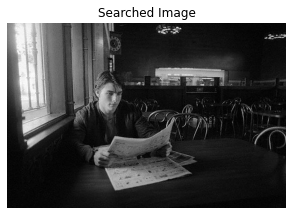

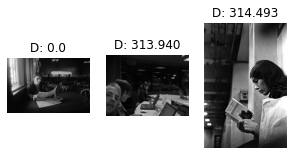

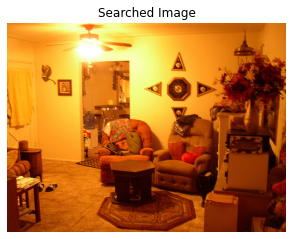

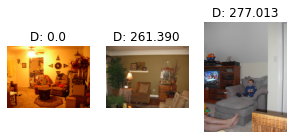

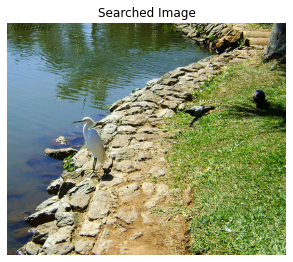

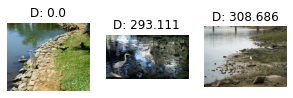

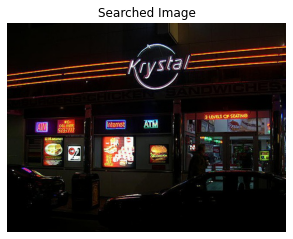

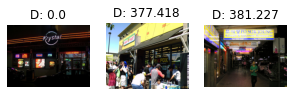

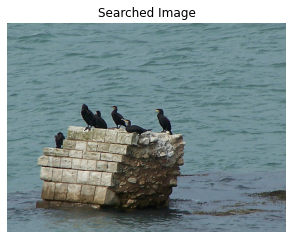

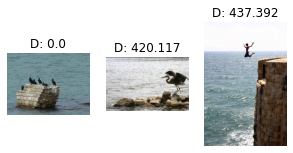

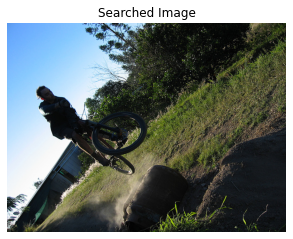

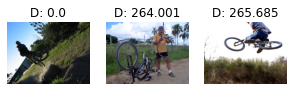

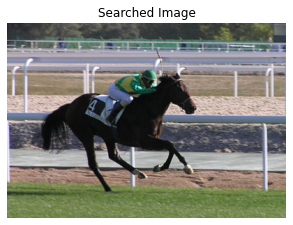

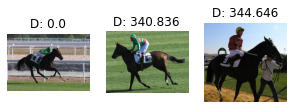

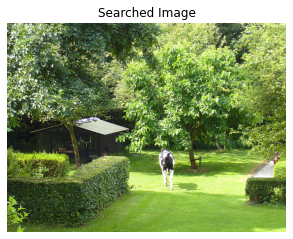

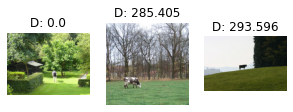

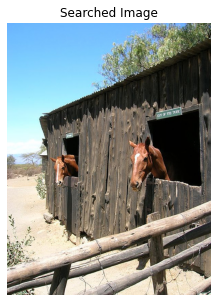

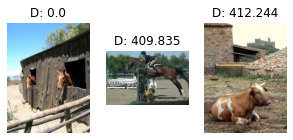

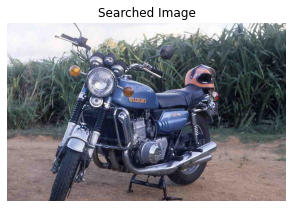

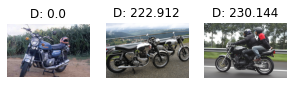

In [11]:
# Preprocess and search for the images. Print query image, results, and result distances.
transform_ops = transforms.Compose([
                transforms.Resize(256),
                transforms.CenterCrop(224),
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])
    

embeddings = [transform_ops(Image.open(x)) for x in search_images]
embeddings = torch.stack(embeddings, dim=0)
print(embeddings.shape)
    
    
with torch.no_grad():
    embeddings = encoder(embeddings).squeeze().numpy()
print(embeddings.shape)

search_sub_param = {
        "nprobe": 16
    }

search_param = {
    'collection_name': collection_name,
    'query_records': embeddings,
    'top_k': 3,
    'params': search_sub_param,
    }


start = time.time()
status, results = milv.search(**search_param)
end = time.time() - start

print("Search took a total of: ", end)

if status.OK():
    for x in range(len(results)):
        query_file = search_images[x]
        result_files = [red.get(y.id).decode('utf-8') for y in results[x]]
        distances = [y.distance for y in results[x]]
        show_results(query_file, result_files, distances)
else:
    print("Search Failed.")

